# Predicting Bitcoin Closing Prices with Machine Learning

---------------------------------

<font size=3.5 ><text><strong>This notebook analyzes crypto currencies values, their correlations and how we can predict next values</strong></text></font>
<br><br>
<strong>What is a crypto currency ?</strong>
<br>
According to wikipedia, a cryptocurrency is a digital asset designed to work as a medium of exchange using "cryptography" to secure the transactions and to control the creation of additional units of the currency by "mining".
<br><br>

<ul>
<li>I     – <a href="#chapI">Get data and explore it</a></li>
<li>II  – <a href="#chapII">What about these time series stationarity ?</a></li>
<li>III – <a href="#chapIII">Vizualize cryptocoins correlations</a></li>
<li>IV  – <a href="#chapIV">Plot the candle stick representation</a></li>
<li>V   – <a href="#chapV">Feature Engineering</a></li>
<li>VI  – <a href="#chapVI">Build a first model</a></li>
<li>VII – <a href="#chapVII">Set more models to tune </a></li>
</ul>

<br><br>
<strong>Data collected</strong>
<br>
You have 5 columns that are :
<br><font color='blue'>Open</font> : the stock price at the begining of the market day
<br><font color='blue'>High</font> : the highest stock price of the day
<br><font color='blue'>Low</font> : the lowest stock price of the day 
<br><font color='blue'>Close</font> : final stock price of the day
<br><font color='blue'>Volume</font> : that define the "volatility" 

<strong>To build a model we will need in this notebook to define a <font color='green'>target feature</font>.</strong>


## <p id="chapI">I - Get cryptocurrencies data from coinmarketcap.com and explore it</p>

---------------



In [90]:
import bs4 as bs
import requests
import pickle
import os
import datetime as dt
import pandas_datareader.data as web
import time

#Search for main cryptocurrency and build the "coinmarketcap" URL to request
def get_cryptocurrency_url_from_coinmarketcap():
    
    #Build a header and request coinmarketcap with it
    home_url='https://coinmarketcap.com/all/views/all/'
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17'}
    resp = requests.get(home_url, headers=headers)
    
    #Get the text from table class 'table' 
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'table js-summary-table'})
    
    #Get the cursor on the current number of crypto currencies
    currency_urls = {}
    cursor=0
    for row in table.findAll('tr')[1:]:                      #Remove header
        if cursor < 100:                                      #Here limit is set to 100
            td_cells = row.findAll('td')
            
            #Get parameters values and register it
            currency_url = td_cells[1].findAll('a')[0].get('href')
            currency_name = td_cells[1].text.replace('\n','').lower()
            market_cap = td_cells[2].text
            currency_urls[currency_name]=currency_url 
            cursor += 1

            
    #Now that we have currency names we will build URL for each 
    start_date = '20160920'
    end_date = '20170920'
    for currency_name,currency_url in currency_urls.items():
         currency_urls[currency_name] = '{}{}historical-data/?start={}&end={}'.format('https://coinmarketcap.com', currency_url, start_date, end_date)
    
    #Check availability to the os path to record all URLs built
    if not os.path.exists('cryptocurrency_urls'):
        os.makedirs('cryptocurrency_urls')

    with open("cryptocurrency_urls/currency_urls","wb") as f:
        pickle.dump(currency_urls,f)
        
    return currency_urls


#Get crypto currencies urls to find data from the web or from a local file
def get_cryptocurrency_url(reload=False):
    #Reload it from the web
    if reload:
        currency_urls = get_cryptocurrency_url_from_coinmarketcap()
    #Or load it from a local file    
    else:
        with open("cryptocurrency_urls/currency_urls","rb") as f:
            currency_urls = pickle.load(f)
    return currency_urls



<font size=3.5><strong>Get historical coin values from the web</strong></font>

In [2]:
import pandas as pd

#Get cryptocurrencies urls
cryptocurrencies_urls = get_cryptocurrency_url(reload=False) 

#function to get data from url and register it into csv files
def get_historical_data():
    
    #Check if the crypto_coins_hist_data exists
    if not os.path.exists('crypto_coins_hist_data'):
        os.makedirs('crypto_coins_hist_data')
    
    #For each currency and its url get historical data
    for i_coin,i_url in cryptocurrencies_urls.items():
        #Build a header and request wikipedia with it
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17'}
        resp = requests.get(i_url, headers=headers)
        
        #Get the text from table class 'table' 
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class': 'table'})
        
        #Get all the historical data : "Date" "Open" "High"  "Low" "Close" "Volume" "Market Cap"
        #First create the coin DataFrame
        coin_df = pd.DataFrame(columns=("Date","Open","High","Low","Close","Volume","MarketCap"))
        i_row=0
        
        #Read each data day tuple
        for row in table.findAll('tr')[1:]:   #Skip the header
                td_cells = row.findAll('td')
                
                c_date = td_cells[0].text
                c_open = td_cells[1].text          
                c_high = td_cells[2].text
                c_low = td_cells[3].text
                c_close = td_cells[4].text
                c_volume = td_cells[5].text
                c_marketcap = td_cells[6].text
                
                #Finally register the current dataframe row
                coin_df.loc[i_row] = [c_date, c_open, c_high, c_low, c_close, c_volume, c_marketcap]                 
                i_row = i_row + 1 
        
        #Write the current coin dataframe to csv
        csv_name = 'crypto_coins_hist_data/{}.csv'.format(i_coin.replace('/',''))
        coin_df.to_csv(csv_name)
        time.sleep(2)
                
            
#Launch the collect historical data process                
get_historical_data()

## Manipulate financial data with SQL to select and compile

-------------------


In [91]:
import os
import pandas as pd
import re
import sqlite3
conn = sqlite3.connect("cryptocurrencies2.db")
cursor = conn.cursor()

def clean_MarketCap_column(row):
    return row["MarketCap"].replace(",","")
    
def clean_Volume_column(row):
    return row["Volume"].replace(",","")


#Read the collected csv files 
data_files = os.listdir('crypto_coins_hist_data')

#Create a metadata table
cursor.execute("DROP TABLE IF EXISTS CRYPTO_METADATA ;")
cursor.execute('create table CRYPTO_METADATA (TABLE_NAME TEXT PRIMARY KEY, MIN_DATE DATE, MAX_DATE DATE, MARKETCAP  INTEGER, VOLUME REAL) ;')

#For each file create a new table in the cryptocurrencies database
for file in data_files:
    df = pd.read_csv('crypto_coins_hist_data\{}'.format(file))    
    
    #Convert date format and others to manipulate it with sqlite easily
    df["Date"] = pd.to_datetime(df.Date, format='%b %d, %Y')
    df["MarketCap"] = df.apply(clean_MarketCap_column, axis=1) 
    df["Volume"] = df.apply(clean_Volume_column, axis=1)
    
    #Rename the table name removing extra characters
    tbl_name = "crypto_" + file.replace('_','').replace('.csv','').replace(' ','').replace('.','').replace("('","").replace("'),","")
    df["Table_name"] = tbl_name
    
    #Convert each file read to sql table
    df.to_sql(tbl_name, conn, if_exists="replace")
    
    #Insert a new row in the metadata table 
    insert_query = "INSERT INTO CRYPTO_METADATA select Table_name, min(Date), max(Date), MarketCap, Volume FROM {} order by date desc limit 1  ;".format(tbl_name)
    cursor.execute(insert_query)
    cursor.execute("COMMIT;")
    
#Check the sqlite3 table list (only 5 firsts tables)
query = "SELECT name FROM sqlite_master WHERE type='table' LIMIT 5;"
print(pd.read_sql_query(query, conn))

C:\Users\Ludovic\Anaconda3\lib\site-packages\pandas\core\generic.py:1362: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


                 name
0     CRYPTO_METADATA
1           crypto_0x
2    crypto_aeternity
3  crypto_aidoskuneen
4       crypto_aragon


<font size = 3.5><strong> Check if we can work on a whole year of data </strong></font>

In [92]:
def show_sql(query):
    return pd.read_sql_query(query, conn)
    

#Select 15 biggest crypto currency on the market
query_top_15 = "select table_name,marketcap,min_date from CRYPTO_METADATA where min_date='2016-09-20 00:00:00' and table_name in (SELECT table_name from CRYPTO_METADATA where marketcap <> '-' ) order by marketcap desc LIMIT 15;"
show_sql(query_top_15)

,TABLE_NAME,MARKETCAP,MIN_DATE
0,crypto_bitcoin,64918500000,2016-09-20 00:00:00
1,crypto_ethereum,26712400000,2016-09-20 00:00:00
2,crypto_ripple,7044160000,2016-09-20 00:00:00
3,crypto_litecoin,2795880000,2016-09-20 00:00:00
4,crypto_dash,2450240000,2016-09-20 00:00:00
5,crypto_nem,2141460000,2016-09-20 00:00:00
6,crypto_monero,1474840000,2016-09-20 00:00:00
7,crypto_ethereumclassic,1094120000,2016-09-20 00:00:00
8,crypto_neo,995012000,2016-09-20 00:00:00
9,crypto_lisk,696190000,2016-09-20 00:00:00


## Import these 15 biggest crypto coin into DataFrame and save it into files

-----------


In [93]:
import copy

#get crypto data to dataframe
def get_crypto_data(table_name):
    query='select Date, Open, High, Low, Close, Volume, MarketCap from crypto_{}'.format(table_name)
    crypto_df = pd.read_sql(query,conn)
    return crypto_df

#create directory if not exists
if not os.path.exists('crypto_data'):
        os.makedirs('crypto_data')
        
#for each selected crypto coin
query="select distinct replace(table_name,'crypto_','') from CRYPTO_METADATA where min_date='2016-09-20 00:00:00' and table_name in (SELECT table_name from CRYPTO_METADATA where marketcap <> '-' ) order by marketcap desc LIMIT 15;"
cursor.execute(query)
for row in cursor:
    print(row[0])
    current_table = row[0] 
    crypto_df = get_crypto_data(current_table)
    csv_file_name = 'crypto_data/{}.csv'.format(current_table)
    crypto_df.to_csv(csv_file_name, index=False)

bitcoin
ethereum
ripple
litecoin
dash
nem
monero
ethereumclassic
neo
lisk
stratis
tether
waves
steem
maidsafecoin


## Read Crypto coins files

In [94]:
#Read data
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
%matplotlib inline

#Set environment
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

#Input data files are available in the ".\data" directory
#List all available files put into "data" directory
import os
data_files = os.listdir('crypto_data')
for file in data_files:
    print(file)


bitcoin.csv
dash.csv
ethereum.csv
ethereumclassic.csv
lisk.csv
litecoin.csv
maidsafecoin.csv
monero.csv
nem.csv
neo.csv
ripple.csv
steem.csv
stratis.csv
tether.csv
waves.csv


In [95]:
import re
#Read the crypto currencies history prices and check the file header 
def read_crypto_file(file_name):
    #read current file and order it
    df = pd.read_csv('./crypto_data/'+file_name, parse_dates=True, index_col=0)
    df = df.sort_index(axis=0 ,ascending=True)
    return df
    
crypto = {}

#Loop on file names and read them
for file_name in data_files:
    #if 'price' in file_name:
        print(file_name)
        coin_name = re.sub(r".csv", "", file_name   )
        crypto[coin_name] = read_crypto_file(file_name)


bitcoin.csv
dash.csv
ethereum.csv
ethereumclassic.csv
lisk.csv
litecoin.csv
maidsafecoin.csv
monero.csv
nem.csv
neo.csv
ripple.csv
steem.csv
stratis.csv
tether.csv
waves.csv


<font size=3.5><strong>Look at firsts lines</strong></font>

In [96]:
crypto['bitcoin'].head()

,Open,High,Low,Close,Volume,MarketCap
Date,,,,,,
2016-09-20,609.25,609.52,607.94,608.31,72710900,9673140000
2016-09-21,603.59,603.59,595.88,597.15,82776200,9584260000
2016-09-22,597.28,598.49,596.21,596.30,67085300,9485280000
2016-09-23,596.20,603.21,595.79,602.84,51067000,9469130000
2016-09-24,602.96,604.58,602.04,602.63,35359500,9577520000


<font size=3.50><strong>Keep only "Close" for values and "Date" for the index </strong></font>

In [97]:
# For this analysis I will only be looking at closing price to make things more manageable
for coin in crypto:
    for coin in crypto:
        crypto[coin] = crypto[coin][["Close"]]
   

In [98]:
crypto['bitcoin'].head()

,Close
Date,
2016-09-20,608.31
2016-09-21,597.15
2016-09-22,596.30
2016-09-23,602.84
2016-09-24,602.63


<font size=3.5>First plot, look at all the <strong><font color="red">bitcoin</font> "Close" </strong> values</font>

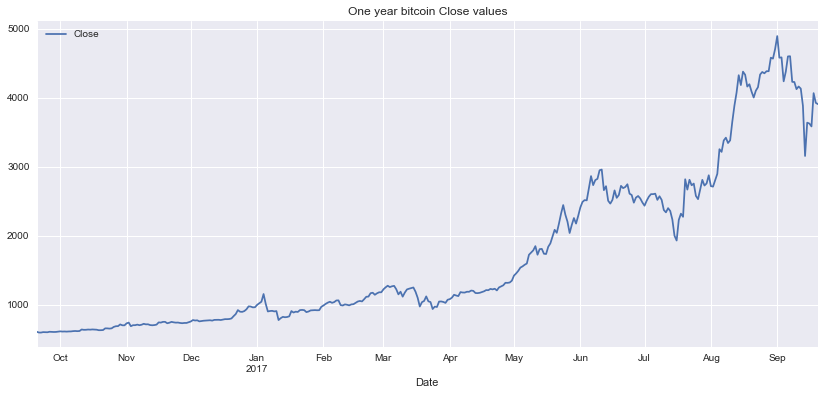

In [99]:
crypto['bitcoin'].plot(figsize = (14,6), title="One year bitcoin Close values")

In [100]:
#Check the depth of the data and the period during which these were collected
print(crypto['bitcoin'].shape)
print(crypto['bitcoin'].idxmin())
print(crypto['bitcoin'].idxmax())

(366, 1)
Close   2016-09-22
dtype: datetime64[ns]
Close   2017-09-01
dtype: datetime64[ns]


In [101]:
#Look at all cryptocurrencies depth history
for coin in crypto:
    print(coin, len(crypto[coin]))



bitcoin 366
dash 366
ethereum 366
ethereumclassic 366
lisk 366
litecoin 366
maidsafecoin 366
monero 366
nem 366
neo 366
ripple 366
steem 366
stratis 366
tether 366
waves 366


<font size=3.5><strong>Plot cryptocurrencies on the last year</strong></font>

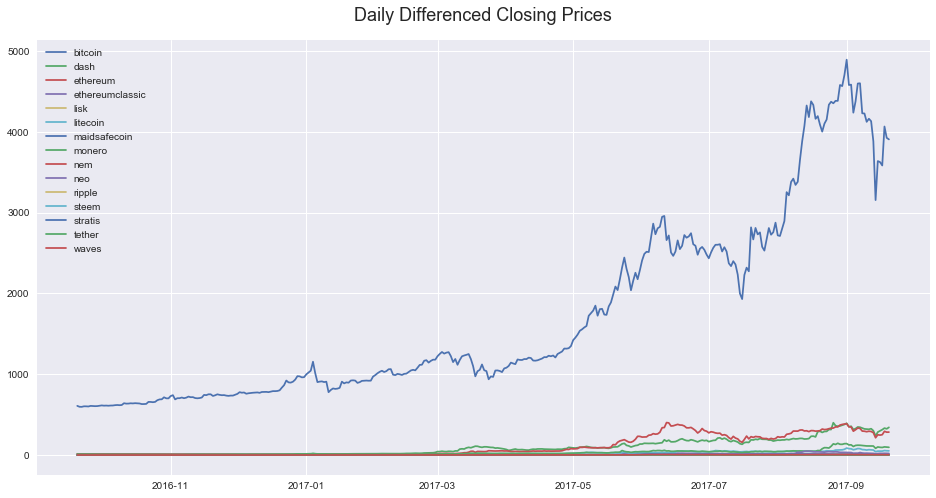

In [102]:
#Plot the daily close bitcoin value
fig, ax = plt.subplots(figsize=(16,8))
for coin in crypto:
    plt.plot(crypto[coin]['Close'], label=coin)
plt.legend(loc=2)
plt.title('Daily Differenced Closing Prices', fontsize = 18, y = 1.03)
plt.show()

We have here a huge difference between bitcoin currency and others. <br>
<strong>Let's move to amount value differences to compare on a new graph.</strong>

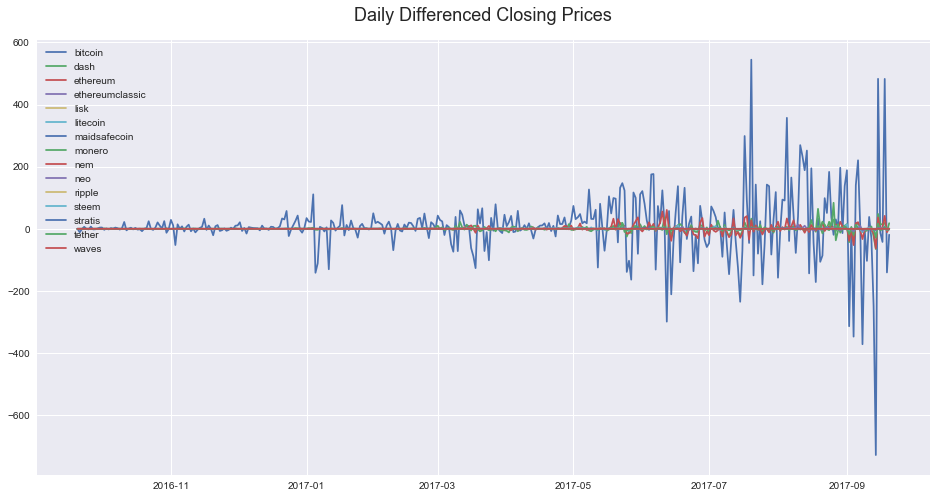

In [103]:
#Look for daily difference

#Get daily differencies
for coin in crypto:
    crypto[coin]['CloseDiff'] = crypto[coin]['Close'].diff().fillna(0)
    
    
#And graph
fig, ax = plt.subplots(figsize=(16,8))
for coin in crypto:
    plt.plot(crypto[coin]['CloseDiff'], label=coin)
plt.legend(loc=2)
plt.title('Daily Differenced Closing Prices', fontsize = 18, y = 1.03)
plt.show()
    

As we have seen, the bitcoin has larger valuation than other crypto currencies. So we observe higher differences.

<strong>Now, move to percentage change from day to day.<br>
What about the new plot ?</strong>

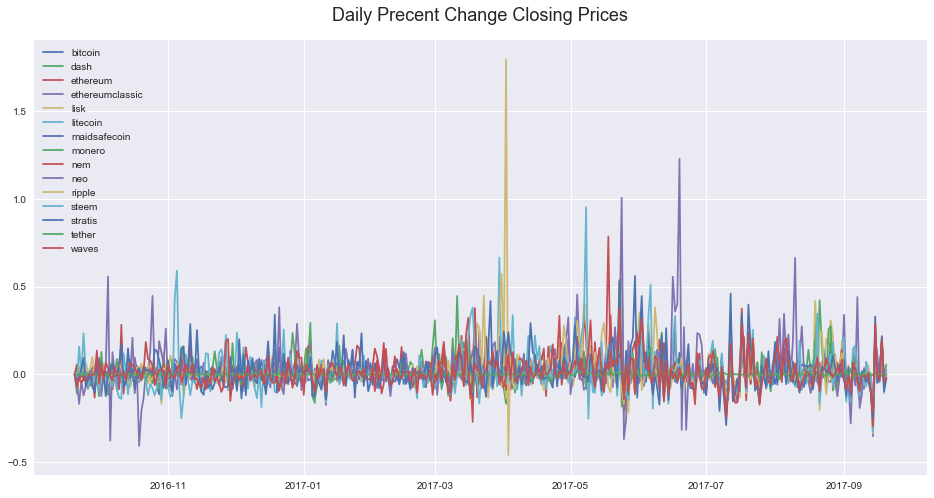

In [104]:
#Get daily differencies
for coin in crypto:
    crypto[coin]['ClosePctChg'] = crypto[coin]['Close'].pct_change().fillna(0)
    
    
#And graph
fig, ax = plt.subplots(figsize=(16,8))
for coin in crypto:
    plt.plot(crypto[coin]['ClosePctChg'], label=coin)
plt.legend(loc=2)
plt.title('Daily Precent Change Closing Prices', fontsize = 18, y = 1.03)
plt.show()

This time we do not distinguish a dominating currency change percentage through days.
<br>But the plot is not so clear to read.
<br> Let's focus on the last 30 days to watch how currencies move each other.

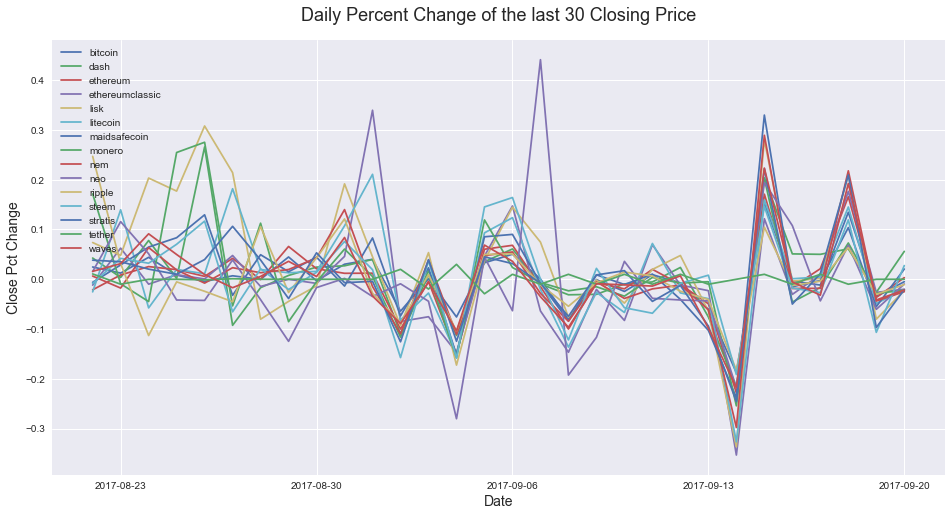

In [105]:
#Now look at the last 30 days
def plot_x_days(xdays):
    fig, ax = plt.subplots(figsize=(16,8))
    for coin in crypto:
        plt.plot(crypto[coin]['ClosePctChg'][-xdays:], label=coin)
    plt.legend(loc=2)
    plt.ylabel("Close Pct Change", fontsize=14)
    plt.xlabel("Date", fontsize=14)
    plt.title('Daily Percent Change of the last {} Closing Price'.format(xdays), fontsize = 18, y = 1.03)
    plt.show()

plot_x_days(30)

We can see here some correlations, let's look at the 10 and 5 last days too

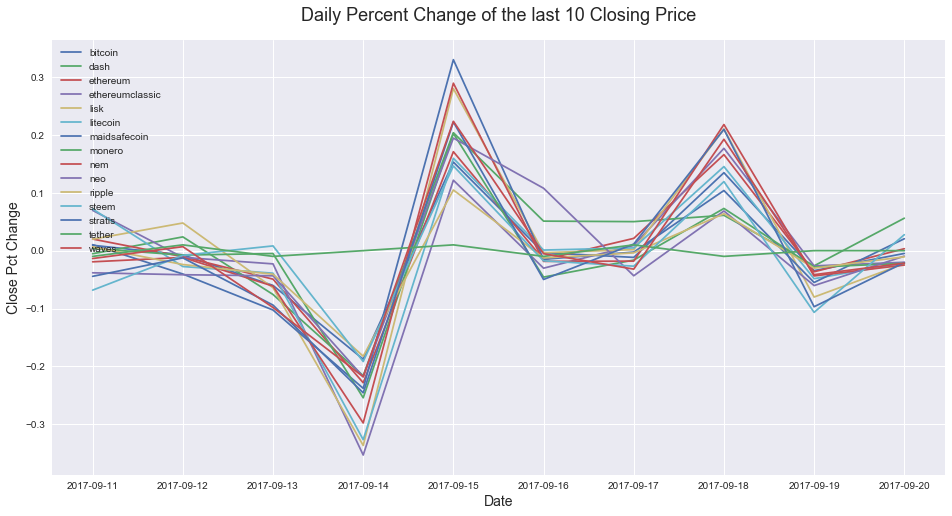

In [106]:
plot_x_days(10)

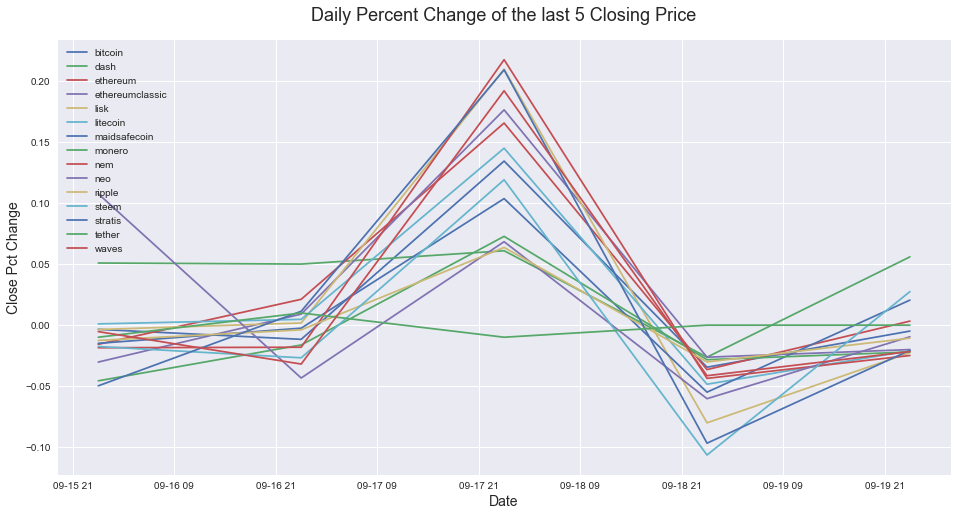

In [107]:
plot_x_days(5)

Here crypto correlations are very clear.

## <p id="chapII">II - What about these time series stationarity ?</p>

---------------------------------



In [108]:
from statsmodels.tsa.stattools import acf, adfuller
for coin in crypto:
    print('\n',coin)
    adf = adfuller(crypto[coin]['ClosePctChg'][1:])
    print(coin, 'ADF Statistic: %f' % adf[0])
    print(coin, 'p-value: %f' % adf[1])
    print(coin, 'Critical Values', adf[4]['1%'])
    print(adf)


 bitcoin
bitcoin ADF Statistic: -19.935390
bitcoin p-value: 0.000000
bitcoin Critical Values -3.44844344752
(-19.935390212341307, 0.0, 0, 364, {'1%': -3.4484434475193777, '5%': -2.8695131705108081, '10%': -2.571017574266393}, -1227.6555567542478)

 dash
dash ADF Statistic: -18.937941
dash p-value: 0.000000
dash Critical Values -3.44844344752
(-18.937940741619474, 0.0, 0, 364, {'1%': -3.4484434475193777, '5%': -2.8695131705108081, '10%': -2.571017574266393}, -840.11244758045405)

 ethereum
ethereum ADF Statistic: -18.447726
ethereum p-value: 0.000000
ethereum Critical Values -3.44844344752
(-18.447725595250713, 2.156182192602846e-30, 0, 364, {'1%': -3.4484434475193777, '5%': -2.8695131705108081, '10%': -2.571017574266393}, -841.05492139843591)

 ethereumclassic
ethereumclassic ADF Statistic: -6.055614
ethereumclassic p-value: 0.000000
ethereumclassic Critical Values -3.44874890515
(-6.0556140464791, 1.247281471434485e-07, 6, 358, {'1%': -3.4487489051519011, '5%': -2.8696473721448728, '

<strong>The Here the serie is stationary. Usually we differenciate and check if the "close percent changing" new serie is stationary looking at the p-value (we will take as it is often the case 5% as our risk threshold)</strong>

In [109]:
for coin in crypto:
    print('\n',coin)
    adf = adfuller(crypto[coin]['CloseDiff'][1:])
    print(coin, 'ADF Statistic: %f' % adf[0])
    print(coin, 'p-value: %f' % adf[1])
    print(coin, 'Critical Values', adf[4]['1%'])
    print(adf)


 bitcoin
bitcoin ADF Statistic: -7.219989
bitcoin p-value: 0.000000
bitcoin Critical Values -3.44874890515
(-7.2199893376588147, 2.1237128512849834e-10, 6, 358, {'1%': -3.4487489051519011, '5%': -2.8696473721448728, '10%': -2.5710891239349585}, 4197.4216440932432)

 dash
dash ADF Statistic: -5.652280
dash p-value: 0.000001
dash Critical Values -3.4491185701
(-5.6522803246871325, 9.7984211895133703e-07, 13, 351, {'1%': -3.4491185700996199, '5%': -2.8698097654570507, '10%': -2.5711757061225153}, 2635.3928481610342)

 ethereum
ethereum ADF Statistic: -5.861640
ethereum p-value: 0.000000
ethereum Critical Values -3.4486972813
(-5.8616404129296829, 3.3995111427876091e-07, 5, 359, {'1%': -3.4486972813047574, '5%': -2.8696246923288418, '10%': -2.571077032068342}, 2707.3934293402999)

 ethereumclassic
ethereumclassic ADF Statistic: -6.320996
ethereumclassic p-value: 0.000000
ethereumclassic Critical Values -3.4486972813
(-6.3209958168093587, 3.0664614834974645e-08, 5, 359, {'1%': -3.448697281

The "difference" serie is stationary as p-value are very low and far under 5%

As we have identified that the series are stationary, we will now search to identify crypto correlations

## <p id="chapIII">III - Vizualize cryptocoins correlations</p>

---------------------------


In [110]:
CloseDf=pd.DataFrame()

for coin in crypto:
    CloseDf[coin] = crypto[coin]['Close']

CloseDfCorr = CloseDf.corr()
CloseDfCorr["bitcoin"]

#Save coin correlation result to file 
CloseDfCorr.to_csv('coin-corr.csv')
    
CloseDfCorr.head()

,bitcoin,dash,ethereum,ethereumclassic,lisk,litecoin,maidsafecoin,monero,nem,neo,ripple,steem,stratis,tether,waves
bitcoin,1.000000,0.967170,0.932438,0.856059,0.899693,0.949844,0.935066,0.928355,0.953829,0.858294,0.790694,0.803821,0.871054,0.139171,0.922006
dash,0.967170,1.000000,0.917542,0.838069,0.926883,0.950116,0.936432,0.955432,0.910830,0.805812,0.762659,0.781156,0.830971,0.102811,0.883312
ethereum,0.932438,0.917542,1.000000,0.962398,0.858859,0.933389,0.943072,0.846964,0.945995,0.716689,0.881710,0.935407,0.957870,0.182973,0.979170
ethereumclassic,0.856059,0.838069,0.962398,1.000000,0.759708,0.902694,0.901518,0.747779,0.909475,0.569439,0.914709,0.948089,0.946964,0.178920,0.941173
lisk,0.899693,0.926883,0.858859,0.759708,1.000000,0.895694,0.895160,0.962833,0.836569,0.742113,0.684272,0.750081,0.780161,0.171662,0.844465


And it appears that they are correlated.<br><br><br>
<font size=3.5><strong>Look at the cryptocoins correlations on a traditional heatmap.</strong></font>

------------------


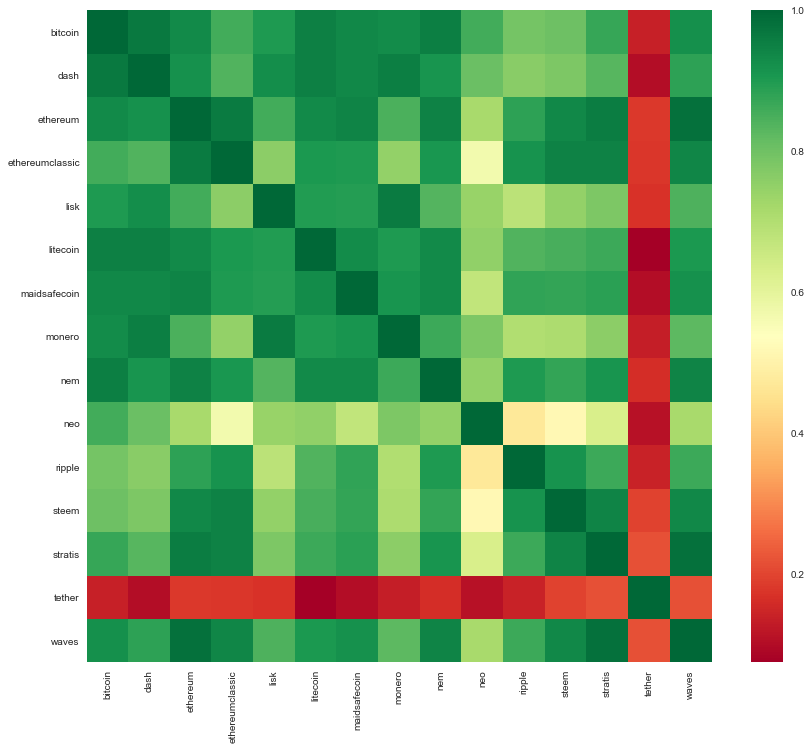

In [111]:
#Use heatmap to watch cross correlations
plt.figure(figsize=(14,12)) 
sns.heatmap(CloseDfCorr, cmap = plt.cm.RdYlGn)



We can sse that tether is the less correlated to other coin currencies

<font size=3.5><b>Add new features from historical data and Vizualize correlation</b></font>

--------------


In [112]:
#Read bitcoin data and add 100ma feature mean value on the last 100 days
bitcoin_df = pd.read_csv('./crypto_data/bitcoin.csv', parse_dates=True, index_col=0)

#Keep only last 365 days
bitcoin_df = bitcoin_df[:365]

#Create a new feature mean on the past 100 days
bitcoin_df['100ma'] = bitcoin_df['Close'].rolling(window=100,min_periods=0).mean()

#Create a new feature mean on the past 20 days
bitcoin_df['20ma'] = bitcoin_df['Close'].rolling(window=20,min_periods=0).mean()

#Create a new feature mean on the past 5 days
bitcoin_df['5ma'] = bitcoin_df['Close'].rolling(window=5,min_periods=0).mean()



<strong> Look at some of the new features</strong>

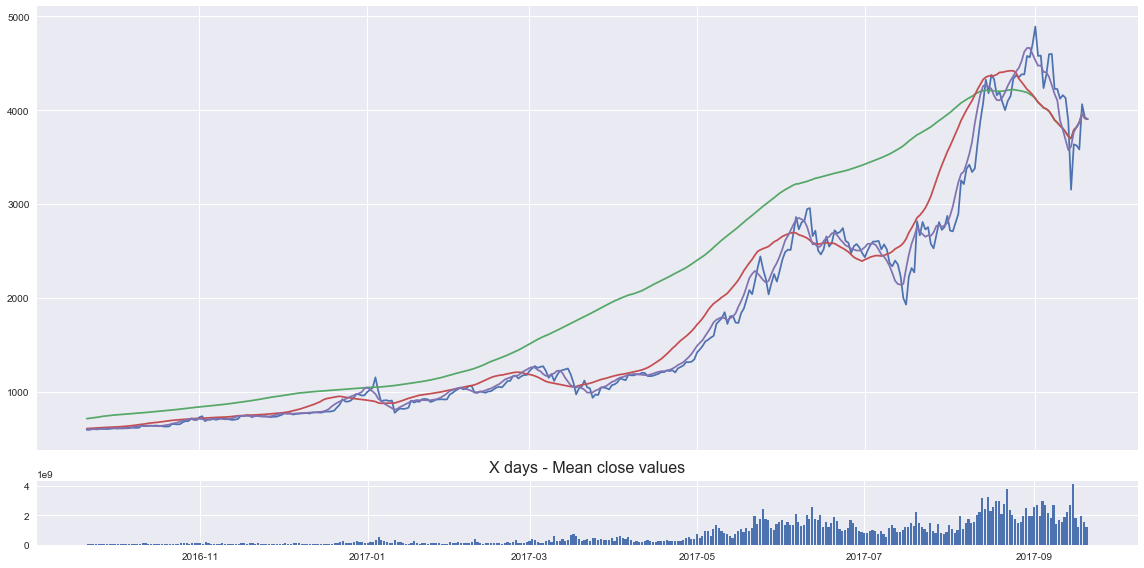

In [113]:
#Size the figure
fig = plt.figure(figsize=(16,8))

#Build plot structure
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1)

#Plot features 
ax1.plot(bitcoin_df.index, bitcoin_df['Close'])
ax1.plot(bitcoin_df.index, bitcoin_df['100ma'])
ax1.plot(bitcoin_df.index, bitcoin_df['20ma'])
ax1.plot(bitcoin_df.index, bitcoin_df['5ma'])
#Remove ax1 xtickslabels
ax1.set_xticklabels([])

ax2.bar(bitcoin_df.index, bitcoin_df['Volume'])

plt.title("X days - Mean close values",fontsize=16, y = 1.03)
plt.tight_layout()
plt.show()

Now use a classic plot for stock values evolution.
<br><br>
## <p id="chapIV">IV - Plot the candle stick representation thanks to candlestick_OHLC</p>

-------------------



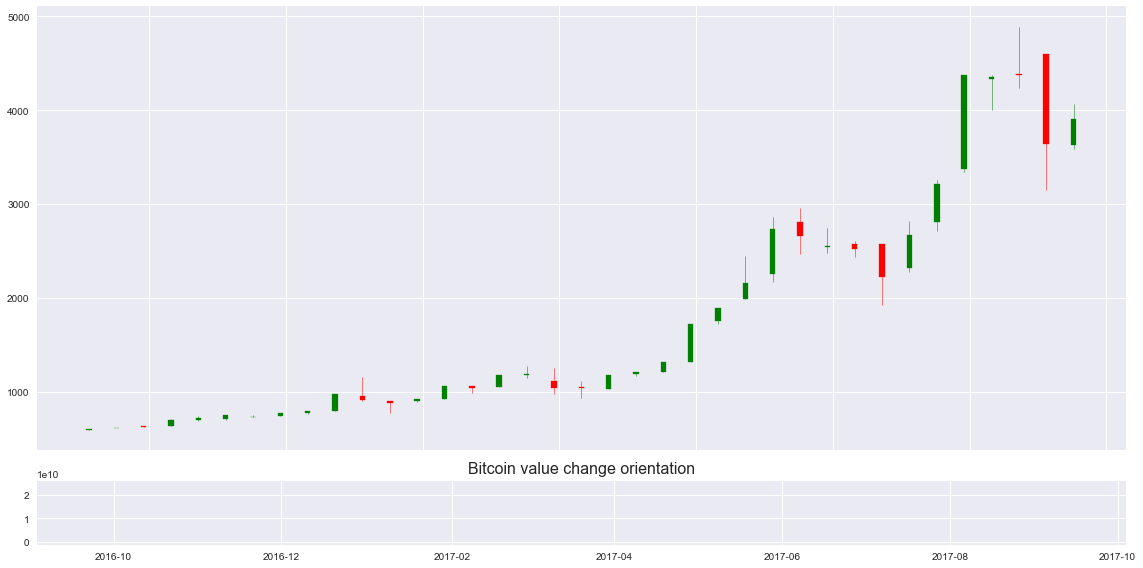

In [114]:
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

#Shrink data other a window of 10 Days
df_ohlc = bitcoin_df["Close"].resample('10D').ohlc()
bitcoin_df["Volume"] = bitcoin_df["Volume"].resample('10D').sum()

#Get Date back among other features 
df_ohlc = df_ohlc.reset_index()
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)

#Prepare the plot structure
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax1.set_xticklabels([])
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1)
ax2.xaxis_date()

#Plot the candlestick
candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
ax2.fill_between(bitcoin_df["Volume"].index.map(mdates.date2num),bitcoin_df["Volume"].values,0)

plt.title("Bitcoin value change orientation",fontsize=16, y = 1.03)
plt.tight_layout()
plt.show()



## <p id="chapV">V - Feature Engineering</p>

------

<font size=3.5><strong>Focus on Bitcoin and process Feature engineering</strong></font>

In [151]:
#Prepare data to create labels for Machine Learning
def process_data_for_labels(coin):
    hm_days = 7
    coins = CloseDf.columns.values.tolist()
    
    for i in range(1,hm_days+1):
        CloseDf['{}_{}d'.format(coin,i)] = (CloseDf[coin].shift(-i) - CloseDf[coin]) / CloseDf[coin]
        
    CloseDf.fillna(0, inplace=True)
    return coins, CloseDf

#Define label according to the requirement
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.035
    for col in cols:
        if col > requirement:
            return 1 #Means BUY
        if col < -requirement:
            return -1 #Means SELL
    return 0 #Means HOLD


from collections import Counter
#Create our 7 new features
def extract_featuresets(coin):
    #Add labels for each crypto coin
    coins, CloseDf = process_data_for_labels(coin)
    
    #Evaluate target 
    CloseDf['{}_target'.format(coin)] = list(map( buy_sell_hold,
                                               CloseDf['{}_1d'.format(coin)],
                                               CloseDf['{}_2d'.format(coin)],
                                               CloseDf['{}_3d'.format(coin)],
                                               CloseDf['{}_4d'.format(coin)],
                                               CloseDf['{}_5d'.format(coin)],
                                               CloseDf['{}_6d'.format(coin)],
                                               CloseDf['{}_7d'.format(coin)] ))

    #Enumerate target values
    vals = CloseDf['{}_target'.format(coin)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data {} spread on the past {} days:{}'.format(coin,CloseDf['bitcoin'].shape[0],Counter(str_vals)))

    #Clean data
    CloseDf.fillna(0, inplace=True)
    CloseDf = CloseDf.replace([np.inf, -np.inf], np.nan)
    CloseDf.dropna(inplace=True)
    
    #Transform Close values by Pct of changed value day to day and keep on cleaning
    df_vals = CloseDf[[i_coin for i_coin in coins]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)

    #Finally set Features and target
    X = df_vals 
    y = CloseDf['{}_target'.format(coin)].values
    
    return X,y,CloseDf

#Init Dataframe that will hold Close values for crypto coins
CloseDf=pd.DataFrame()

#Focus on the "bitcoin" crypto currency    
CloseDf['bitcoin'] = crypto['bitcoin']['Close']

X, y, df = extract_featuresets('bitcoin')

#Create a new feature mean on the past 100 days
df['5ma'] = CloseDf['bitcoin'].rolling(window=5,min_periods=0).mean()

#Create a new feature mean on the past 20 days
df['20ma'] = CloseDf['bitcoin'].rolling(window=20,min_periods=0).mean()

X = pd.concat([ X, df['5ma'], df['20ma']],axis=1 ) 
for col in CloseDf.columns:
    if col != 'bitcoin_target':
        X = pd.concat([ X, CloseDf[col]],axis=1 ) 

X.head()    



Data bitcoin spread on the past 366 days:Counter({'1': 211, '-1': 89, '0': 66})


,bitcoin,5ma,20ma,bitcoin,bitcoin_1d,bitcoin_2d,bitcoin_3d,bitcoin_4d,bitcoin_5d,bitcoin_6d,bitcoin_7d
Date,,,,,,,,,,,
2016-09-20,0.000000,608.310000,608.310000,608.31,-0.018346,-0.019743,-0.008992,-0.009337,-0.012296,-0.000444,-0.003518
2016-09-21,-0.018346,602.730000,602.730000,597.15,-0.001423,0.009529,0.009177,0.006163,0.018237,0.015105,0.012694
2016-09-22,-0.001423,600.586667,600.586667,596.30,0.010968,0.010615,0.007597,0.019688,0.016552,0.014137,0.015747
2016-09-23,0.010968,601.150000,601.150000,602.84,-0.000348,-0.003334,0.008626,0.005524,0.003135,0.004728,0.011446
2016-09-24,-0.000348,601.446000,601.446000,602.63,-0.002987,0.008977,0.005874,0.003485,0.005078,0.011798,0.018834


We do not have here something looking like a normal distribution.<br>
We mainly look at an increasing value.
We can think that 366 days is a small historical dataset.
During this last year (before 20/09/2017) bitcoin increased mainly because of the Brexit.
The main problem of this new currency is that only few people understand how it works...


<font size =3.5><strong>Use Standard scaler to normalize data </strong></font>

---------------


In [152]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X) 


## <p id="chapVI">VI - Build a first model</p>

------------

<font size=3.5><strong> Try a first model with RandomForestClassifier </strong></font>

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split

# The fit and predict function
def fit_and_predict(X, use_gs=False):
    
    #X, y, df = extract_featuresets(coin)
    
    # Split data to train and test the model 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3)
    
    if use_gs:
        # RandomForest is known to obtain good result, let's begin with it
        clf = RandomForestClassifier(oob_score=True,
                                random_state=1,
                                n_jobs=-1)
        param_grid = { "max_features" : ["auto","sqrt"],
                    "criterion"   : ["gini", "entropy"],
                    "min_samples_leaf" : [1,4],
                    "min_samples_split" : [ 4, 10, 12, 16],
                    "n_estimators": [50, 100, 400, 600]}
        
        # GridSearch for hyperparameter tuning
        gs = GridSearchCV(estimator=clf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)
        # Fit and predict
        gs = gs.fit(X_train, Y_train)
        predictions = gs.predict(X_test)
        
        # Inspect best parameters
        print('Score :')
        print(gs.best_score_)
        print(gs.best_params_)
        
    
    
# Init Dataframe that will hold Close values for crypto coins
CloseDf=pd.DataFrame()
for coin in crypto:
    CloseDf[coin] = crypto[coin]['Close']

# Launch GridSearch and tune RandomForest hyperparameters for the bitcoin 
gs_bool=True    
fit_and_predict(scaled_X, gs_bool)



Score :
0.90625
{'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


<font size=3.5><strong>Estimation selector Helper</strong></font>

-----------------


In [154]:
class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=-1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                               scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]
    
    
    




## <p id="chapVII">VII - Set more models to tune and their parameters</p>

---------------


In [155]:
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC

models1 = { 
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC()
}


params1 = { 
    'ExtraTreesClassifier': { 'n_estimators': [32, 64, 128, 256, 512] },
    'RandomForestClassifier': { "n_estimators": [32, 64, 128, 256], 
                                "max_features" : ["auto","sqrt"],
                                "criterion"   : ["gini", "entropy"],
                                "min_samples_leaf" : [1,4,8],
                                "min_samples_split" : [ 4, 12, 16, 32] },
    'AdaBoostClassifier':  {"n_estimators": [32, 64, 128, 256, 512], 
                            "learning_rate": [0.01, 0.05, 0.1, 0.4, 0.8] },
    'GradientBoostingClassifier': {"n_estimators": [64, 128, 256, 512],
                                   "min_samples_leaf" : [1,4],
                                   "min_samples_split" : [ 4, 12, 16],
                                   "learning_rate": [0.01, 0.1, 0.4, 0.8] },
    'SVC': [
        {'kernel': ['linear'], 'C': [0.5, 1, 2, 5, 10]},
        {'kernel': ['rbf'], 'C': [1, 2, 5, 10], 'gamma': [0.1, 0.01, 0.001, 0.0001]},
    ]
}

In [156]:
from datetime import datetime

print(str(datetime.now()))
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(scaled_X, y, scoring='accuracy', n_jobs=-1)
print(str(datetime.now()))

2017-09-29 00:46:28.417110
Running GridSearchCV for ExtraTreesClassifier.
Running GridSearchCV for RandomForestClassifier.
Running GridSearchCV for AdaBoostClassifier.
Running GridSearchCV for GradientBoostingClassifier.
Running GridSearchCV for SVC.
2017-09-29 00:48:59.694642


In [157]:
helper1.score_summary(sort_by='mean_score')

C:\Users\Ludovic\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\Ludovic\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\Ludovic\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\Ludovic\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: T

,estimator,min_score,mean_score,max_score,std_score,C,criterion,gamma,kernel,learning_rate,max_features,min_samples_leaf,min_samples_split,n_estimators
215,AdaBoostClassifier,0.85124,0.898812,0.959016,0.0448973,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,256
216,AdaBoostClassifier,0.842975,0.898722,0.942623,0.0415345,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,512
214,AdaBoostClassifier,0.842975,0.890637,0.959016,0.0495871,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,128
209,AdaBoostClassifier,0.834711,0.890525,0.934426,0.0415712,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,128
208,AdaBoostClassifier,0.801653,0.884948,0.942623,0.0603349,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,64
220,AdaBoostClassifier,0.834711,0.882373,0.92623,0.0374592,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,256
219,AdaBoostClassifier,0.834711,0.879707,0.942623,0.0458408,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,128
203,AdaBoostClassifier,0.785124,0.879439,0.942623,0.0679623,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,64
221,AdaBoostClassifier,0.809917,0.876841,0.934426,0.0512576,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,512
210,AdaBoostClassifier,0.801653,0.876818,0.942623,0.0579302,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,256


<font size=3.5><strong>Use of a confusion matrix to point out the poorest predictions</strong></font>

-------------


Normalized confusion matrix
[[ 0.65  0.    0.35]
 [ 0.    0.    1.  ]
 [ 0.    0.    1.  ]]


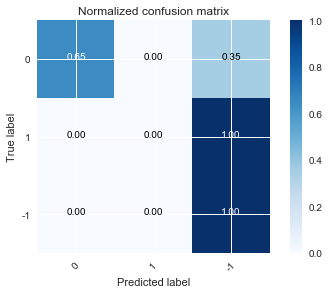

In [159]:
from itertools import product
from sklearn.metrics import confusion_matrix

# Split data to train and test the model 
X_train,X_test,Y_train,Y_test = train_test_split(scaled_X,y,test_size=0.3)

#Instantiate the model with selected parameters
adb = AdaBoostClassifier(learning_rate=0.4, n_estimators=512, random_state=0)

#Train the SVM classifier
adb.fit(X_train, Y_train)
# Predict 
Y_predicted = svm.predict(X_test)


#Now plot the confusion matrix
def plot_confusion_matrix(cm,        #confusion matrix to plot 
                          classes,   #labels
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    print(cm)

    #Set the plot parameters
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    
    #Display confusion matrix values on the image cells
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_predicted)
np.set_printoptions(precision=2)

#Define class_names
class_names = df['bitcoin_target'].unique()

#Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Normalized confusion matrix')

plt.show()

To improve our predictions we would have here to look for new features able to define a pattern for "Buy" trade on bitcoin that are not predicted correctly.